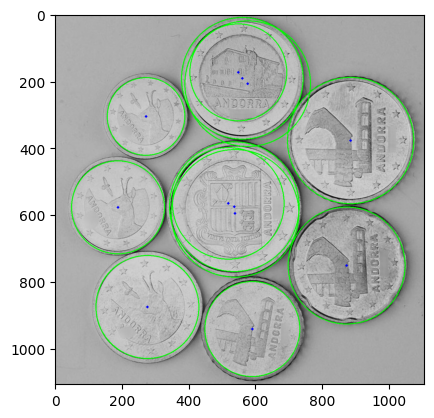

In [91]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('inputs/coins.jpg', 0)

# Blur the image to improve detection
img = cv2.medianBlur(img, 3)

# Convert the image to grayscale
cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Perform the Hough Transform
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20,
                           param1=410, param2=80, minRadius=110, maxRadius=195)

# Convert the circles to integers
circles = np.uint16(np.around(circles))

# Draw the circles on the original image
for i in circles[0, :]:
    # Draw the outer circle
    cv2.circle(cimg, (i[0], i[1]), i[2], (0, 255, 0), 2)
    # Draw the center of the circle
    cv2.circle(cimg, (i[0], i[1]), 2, (0, 0, 255), 3)

import matplotlib.pyplot as plt

plt.imshow(cimg)

In [84]:
def dbscan(points, eps, min_samples):
    labels = np.zeros(len(points), dtype=int) - 1 # -1 means unvisited
    C = 0  # Cluster counter

    # Distance calculation function
    def dist(p1, p2):
        return np.linalg.norm(p1 - p2)

    # Region query function
    def region_query(P):
        neighbors = []
        for Pn in range(0, len(points)):
            if dist(points[P], points[Pn]) < eps:
                neighbors.append(Pn)
        return neighbors

    # Grow cluster function
    def expand_cluster(P, neighbors):
        labels[P] = C
        i = 0
        while i < len(neighbors):
            Pn = neighbors[i]
            if labels[Pn] == -1: # point Pn is noise
                labels[Pn] = C
                Pn_neighbors = region_query(Pn)
                if len(Pn_neighbors) >= min_samples:
                    neighbors = neighbors + Pn_neighbors
            elif labels[Pn] == 0: # point Pn is unvisited
                labels[Pn] = C
            i += 1

    # Main loop
    for P in range(0, len(points)):
        if labels[P] != 0:
            continue
        neighbors = region_query(P)
        if len(neighbors) < min_samples:
            labels[P] = -1  # Label as noise
        else:
            C += 1
            expand_cluster(P, neighbors)

    return labels


def mean_radius_cluster(circles, clusters):
    # Initialize a list to store mean radii
    mean_radii = []

    # Iterate through each cluster
    for cluster in clusters:
        # Extract the radii of the circles that are in this cluster
        radii = [circles[0, np.where((circles[0,:,0] == center[0]) & (circles[0,:,1] == center[1]))[0], 2][0] for center in cluster]

        # Calculate the mean radius
        mean_radius = np.mean(radii)

        # Add the mean radius to our list
        mean_radii.append(mean_radius)

    return mean_radii

def mean_center(cluster):
    # Convert cluster to numpy array
    cluster = np.array(cluster)
    return np.mean(cluster, axis=0)


# Load the centers of the circles into a numpy array
centers = np.array([circle[:2] for circle in circles[0, :]])

# Find clusters
clusters = dbscan(centers, 400, 2)

# Print the clusters
for i, cluster in enumerate(clusters):
    print(f'Cluster {i + 1}: {cluster}')

# Calculate the mean radii for each cluster
mean_radii = mean_radius_cluster(circles, clusters)

# Print the mean radii
for i, mean_radius in enumerate(mean_radii):
    print(f'Mean radius of cluster {i + 1}: {mean_radius}')

# Calculate the mean centers for each cluster
mean_centers = [mean_center(cluster) for cluster in clusters]

# Calculate the mean radii for each cluster
mean_radii = mean_radius_cluster(circles, clusters)

# Draw the mean centers and circles of mean radii on the image
for center, radius in zip(mean_centers, mean_radii):
    # Draw the center of the cluster
    cv2.circle(cimg, tuple(center.astype(int)), 2, (255, 0, 0), 3)
    # Draw the circle with mean radius
    cv2.circle(cimg, tuple(center.astype(int)), int(radius), (255, 0, 0), 2)

# Display the image with matplotlib
plt.imshow(cimg)
plt.show()



Cluster 1: -1
Cluster 2: -1
Cluster 3: -1
Cluster 4: -1
Cluster 5: -1
Cluster 6: -1
Cluster 7: -1
Cluster 8: -1
Cluster 9: -1
Cluster 10: -1
Cluster 11: -1


TypeError: 'numpy.int64' object is not iterable

In [87]:
def cluster_points(points):
    # Initialize a list to store clusters, each point is its own cluster at the start
    clusters = [[point] for point in points]

    while len(clusters) > 7:
        # Compute the pairwise distances between cluster centroids
        centroids = [np.mean(cluster, axis=0) for cluster in clusters]
        distances = np.linalg.norm(np.subtract(centroids[:-1], centroids[1:]), axis=1)

        # Find the two closest clusters
        min_distance_index = np.argmin(distances)

        # Merge the two closest clusters
        clusters[min_distance_index] += clusters[min_distance_index + 1]

        # Remove the merged cluster from the list
        del clusters[min_distance_index + 1]

    return clusters

# Load the centers of the circles into a numpy array
centers = np.array([circle[:2] for circle in circles[0, :]])

# Find clusters
clusters = cluster_points(centers)
centers

array([[884, 378],
       [536, 576],
       [558, 190],
       [276, 876],
       [872, 752],
       [590, 940],
       [272, 306],
       [188, 578],
       [568, 212],
       [536, 598],
       [518, 566]], dtype=uint16)

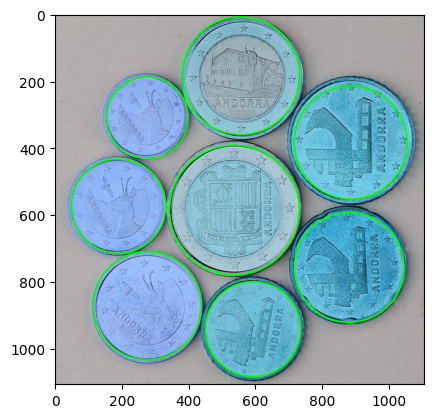

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_util(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    gray_blurred = cv2.GaussianBlur(gray, (7, 7), 1.5)

    # Apply Canny edge detection
    edged = cv2.Canny(gray_blurred, 200, 300)
    #plt.imshow(edged)

    # Perform a dilation and erosion to close gaps in between object edges
    dilated_edged = cv2.dilate(edged.copy(), None, iterations=5)
    eroded_edged = cv2.erode(dilated_edged.copy(), None, iterations=5)
    plt.imshow(eroded_edged)
    
    # Perform a circle Hough Transform to detect the coins
    circles = cv2.HoughCircles(eroded_edged, cv2.HOUGH_GRADIENT, 1, 110, param1=400, param2=20, minRadius=110, maxRadius=195)
    
    # Ensure at least some circles were found
    if circles is not None:
        # Convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        # Loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            # Draw the circle in the output image
            cv2.circle(img, (x, y), r, (0, 255, 0), 4)

    return img

# Load the image
img = cv2.imread('inputs/coins.jpg', 1)
plt.imshow(img)
plt.imshow(segment_util(img))

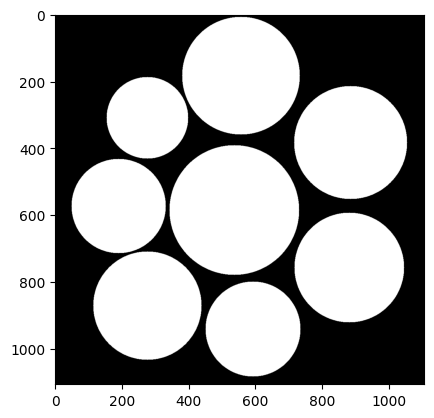

In [13]:
def segment_util(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    plt.savefig('outputs/1_gray.png')

    # Apply Gaussian blur
    gray_blurred = cv2.GaussianBlur(gray, (7, 7), 1.5)
    plt.imshow(gray_blurred)
    plt.savefig('outputs/2_blurred.png')

    # Apply Canny edge detection
    edged = cv2.Canny(gray_blurred, 200, 300)
    plt.imshow(edged)
    plt.savefig('outputs/3_edges.png')

    # Perform a dilation and erosion to close gaps in between object edges
    dilated_edged = cv2.dilate(edged.copy(), None, iterations=5)
    eroded_edged = cv2.erode(dilated_edged.copy(), None, iterations=5)
    plt.imshow(eroded_edged)
    plt.savefig('outputs/4_eroded_dilated.png')

    # Perform a circle Hough Transform to detect the coins
    circles = cv2.HoughCircles(eroded_edged, cv2.HOUGH_GRADIENT, 1, 110, param1=400, param2=20, minRadius=110, maxRadius=195)

    # Create a black image with the same dimensions as the original
    img_seg = np.zeros(img.shape, dtype=np.uint8)

    # Ensure at least some circles were found
    if circles is not None:
        # Convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        # Loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            # Draw the circle in the output image
            cv2.circle(img_seg, (x, y), r, (255, 255, 255), -1)  # -1 indicates to fill the circle

    return img_seg.astype(bool)

# Load the image
img = cv2.imread('inputs/coins.jpg', 1)
plt.imshow(segment_util(img) * 255)

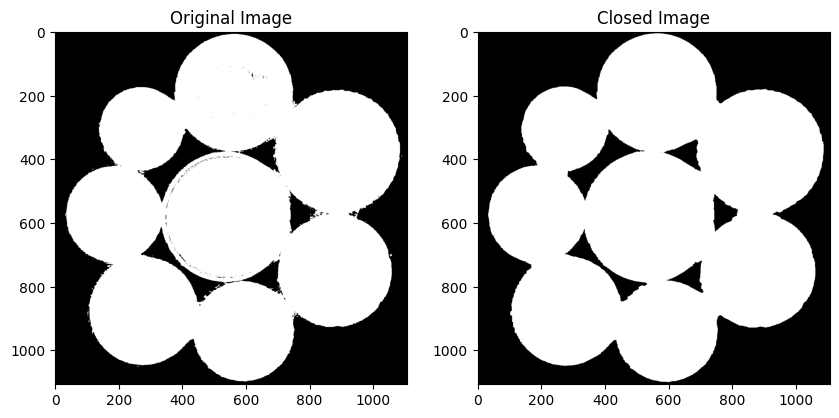

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def close_hole_util(img):
    """
    Given the segmented image, use morphology techniques to close the holes
    Input:
        img:        n x m, values are within [0,1]
    Output:
        closed_img: n x m
    """
    # Apply dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    dilated_img = cv2.dilate(img, kernel, iterations=1)

    # Apply erosion
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    closed_img = cv2.erode(dilated_img, kernel, iterations=5)

    # Apply dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    closed_img = cv2.dilate(closed_img, kernel, iterations=5)

    return closed_img

# Read the image
img = cv2.imread('inputs/coins_seg.png', 0)

# Perform closing operation
closed_img = close_hole_util(img)

# Plot original and processed image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(closed_img, cmap='gray')
plt.title('Closed Image')
plt.show()


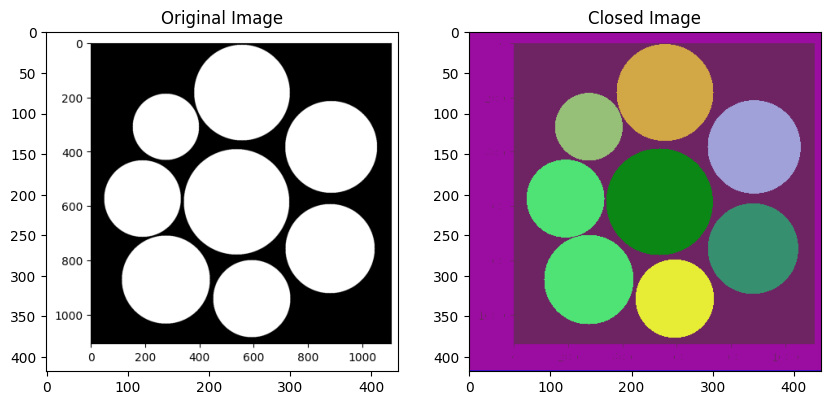

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def watershed_segment(img):
    """
    Given the segmented image, use morphology techniques to close the holes
    Input:
        img:        n x m, values are within [0,1]
    Output:
        closed_img: n x m
    """

    # Find connected components
    _, labeled_img = cv2.connectedComponents(img)
    labeled_img = labeled_img.astype(np.int32)
    labeled_img += 1

    img = cv2.merge((img, img, img))
    closed_img = cv2.convertScaleAbs(img)

    watershed = cv2.watershed(img, labeled_img)

    for segment in np.unique(watershed):
        closed_img[watershed == segment] = [255 * random.random(),
                                            255 * random.random(),
                                            255 * random.random()]

    labeled_img = closed_img * 255

    return labeled_img

# Read the image
img = cv2.imread('results/segmented_hough_bepohl.png', 0)

# Perform closing operation
test = watershed_segment(img)

# Plot original and processed image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(test, cmap='gray')
plt.title('Closed Image')
plt.show()
